In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
from scipy import stats
import random
from scipy.signal import find_peaks

In [2]:
root_dir = "../DataBarCrawl/"
list_dir =sorted(os.listdir(root_dir))
list_dir

['README.txt',
 'all_accelerometer_data_pids_13.csv',
 'clean_tac',
 'phone_types.csv',
 'pids.txt',
 'raw_tac']

In [3]:
os.chdir(root_dir)
dataFile = list_dir[1]
data = pd.read_csv(dataFile)
data.head()

,time,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163


In [4]:
data.shape

(14057567, 5)

In [5]:
data['time'].dtype

dtype('int64')

## Clean data and drop rows where timestamp is 0 . Order the data in ascending order of user and timestamp

In [6]:
data = data[data['time'] != 0]
data = data.sort_values(by=['pid','time'],ignore_index=True)

In [7]:
data.head()

,time,pid,x,y,z
0,1493735870653,BK7610,0.1261,-0.0078,-0.0243
1,1493735870679,BK7610,0.1336,-0.0697,-0.0446
2,1493735870703,BK7610,0.1443,-0.0474,-0.0447
3,1493735870729,BK7610,0.1255,-0.0038,0.0111
4,1493735870753,BK7610,0.1076,0.0032,0.0276


## Read the TAC readings file

In [8]:
os.chdir(root_dir)
tac_dir = "/clean_tac"
os.chdir(root_dir + tac_dir)
tacLsdir = os.listdir()
tacs = {}
for pid_csv in tacLsdir:
    pid = pid_csv[:6]
    # print(pid)
    tacs[pid] = pd.read_csv(pid_csv)

In [9]:
# tacs
pid_acc_data={}
pids = list(tacs.keys())
for pid in pids:
    pid_acc_data[pid] = data[data['pid']==pid]

In [10]:
pid_acc_data['BK7610']

,time,pid,x,y,z
0,1493735870653,BK7610,0.1261,-0.0078,-0.0243
1,1493735870679,BK7610,0.1336,-0.0697,-0.0446
2,1493735870703,BK7610,0.1443,-0.0474,-0.0447
3,1493735870729,BK7610,0.1255,-0.0038,0.0111
4,1493735870753,BK7610,0.1076,0.0032,0.0276
...,...,...,...,...,...
1225722,1493767770540,BK7610,-0.0784,-0.0161,0.1719
1225723,1493767770564,BK7610,-0.0395,-0.0816,0.1634
1225724,1493767770590,BK7610,0.0160,-0.0853,0.0906
1225725,1493767770614,BK7610,0.0901,-0.0767,0.0162


In [11]:
all_data = []
for pid in pids:
    df1 = tacs[pid]
#     Shift TAC reading by 45 minutes before merging with accelerometer data
    # df1['shift_timestamp'] = df1['timestamp'] - (45*60)
    df2 = data[data['pid']==pid]
#     Change timestamp in accelerometer data from milisec to sec
    df2['timestamp'] = df2['time']//1000 
#     Merge the TAC reading and accelerometer data on timestamp
    tmp = df1.merge(df2, on='timestamp')
    tmp['label'] = np.where(tmp['TAC_Reading']<0.08, 0, 1)

    all_data.append(tmp)
large_df = pd.concat(all_data)

<ipython-input-11-69e6b389a0e7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'] = df2['time']//1000


In [12]:
large_df.head()

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493737046,0.065357,1493737046023,BK7610,0.1410,-0.2686,-0.1372,0
1,1493737046,0.065357,1493737046063,BK7610,0.1714,-0.2722,-0.1208,0
2,1493737046,0.065357,1493737046073,BK7610,0.3328,-0.1353,-0.2548,0
3,1493737046,0.065357,1493737046101,BK7610,0.2822,-0.0375,-0.2816,0
4,1493737046,0.065357,1493737046134,BK7610,0.1847,0.1813,-0.2680,0


<ipython-input-10-170ba00cb360>:3: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=large_df[large_df['pid']=="BK7610"])
<ipython-input-10-170ba00cb360>:4: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=large_df[large_df['pid']=="BK7610"])


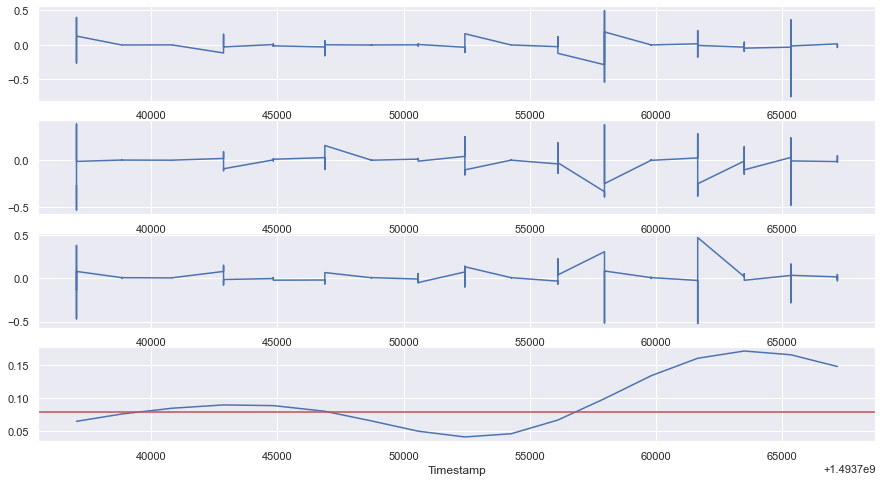

In [ ]:
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=large_df[large_df['pid']=="BK7610"])
ax[1].plot("timestamp","y",data=large_df[large_df['pid']=="BK7610"])
ax[2].plot("timestamp","z",data=large_df[large_df['pid']=="BK7610"])
ax[3].plot("timestamp",'TAC_Reading', data=large_df[large_df['pid']=="BK7610"])
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

In [ ]:
large_df.timestamp.dtype

dtype('int64')

##  Sampling for 800 rows -> 20 seconds of timestamp 

<ipython-input-12-cb14841ac0ac>:5: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=zoomed)
<ipython-input-12-cb14841ac0ac>:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=zoomed)


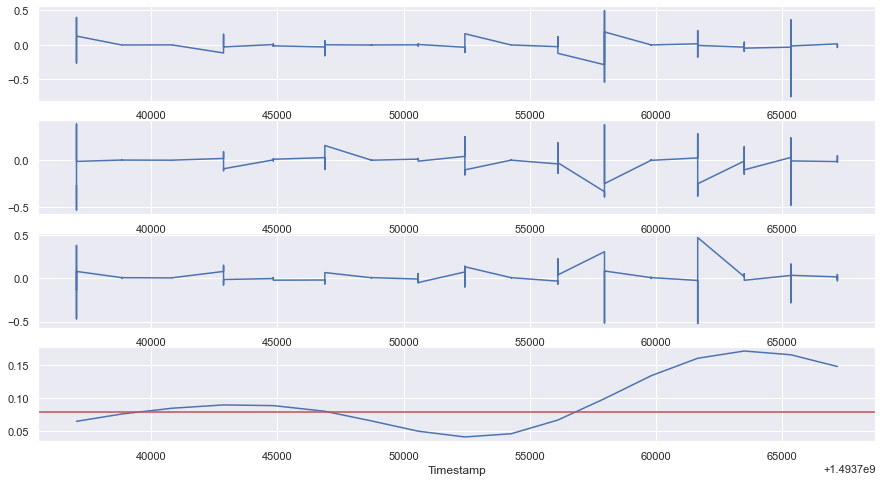

In [12]:
BK7 = large_df[large_df['pid']=="BK7610"]
zoomed = BK7[:800]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=zoomed)
ax[1].plot("timestamp","y",data=zoomed)
ax[2].plot("timestamp","z",data=zoomed)
ax[3].plot("timestamp",'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

<ipython-input-13-19629a461386>:7: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot(time,"x",data=zoomed)
<ipython-input-13-19629a461386>:9: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot(time,"y",data=zoomed)


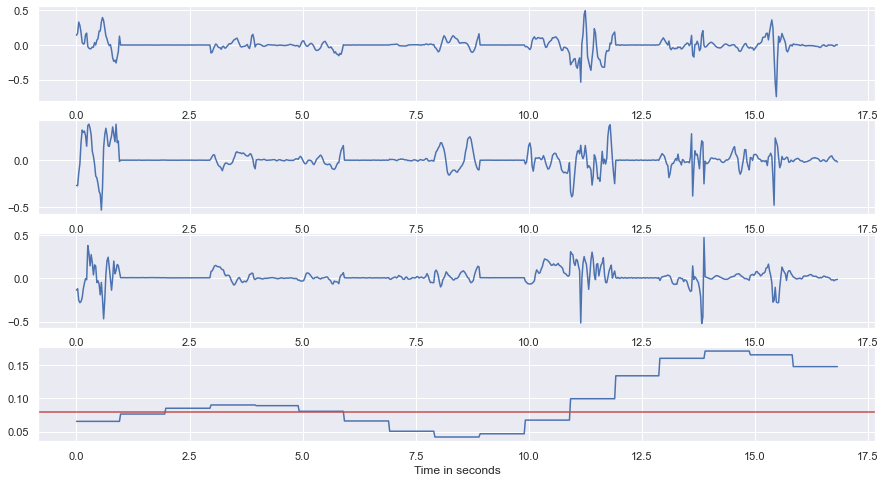

In [13]:
sampling_freq = 40
BK7 = large_df[large_df['pid']=="BK7610"]
zoomed = BK7[:800]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Time in seconds")
time = np.arange(zoomed['x'].size)/sampling_freq
ax[0].plot(time,"x",data=zoomed)
# ax[0].label(y="x axis")
ax[1].plot(time,"y",data=zoomed)
# plt.ylabel("y axis")
ax[2].plot(time,"z",data=zoomed)
# plt.ylabel("z axis")
ax[3].plot(time,'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

Zooming on 10 seconds

<ipython-input-14-c8f1ed5c67c7>:4: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=zoomed)
<ipython-input-14-c8f1ed5c67c7>:5: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=zoomed)


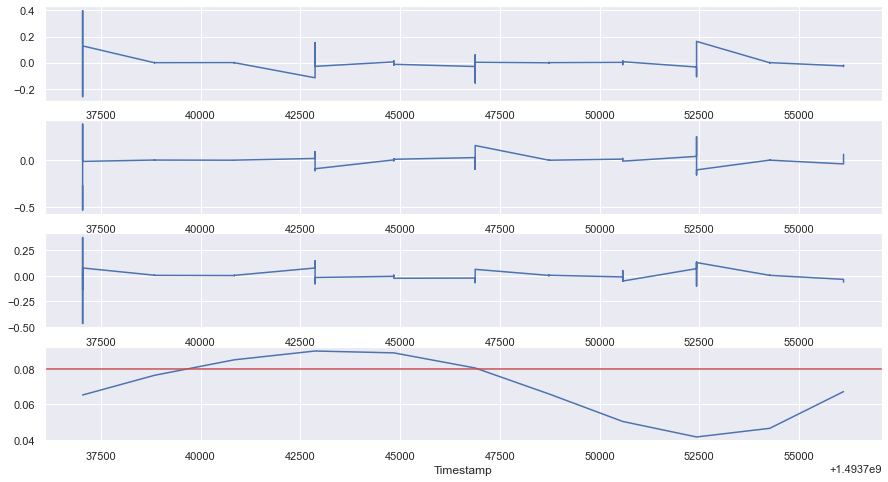

In [14]:
zoomed = BK7[:400]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=zoomed)
ax[1].plot("timestamp","y",data=zoomed)
ax[2].plot("timestamp","z",data=zoomed)
ax[3].plot("timestamp",'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

<ipython-input-15-e2abf304d28f>:5: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot(time,"x",data=zoomed)
<ipython-input-15-e2abf304d28f>:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot(time,"y",data=zoomed)


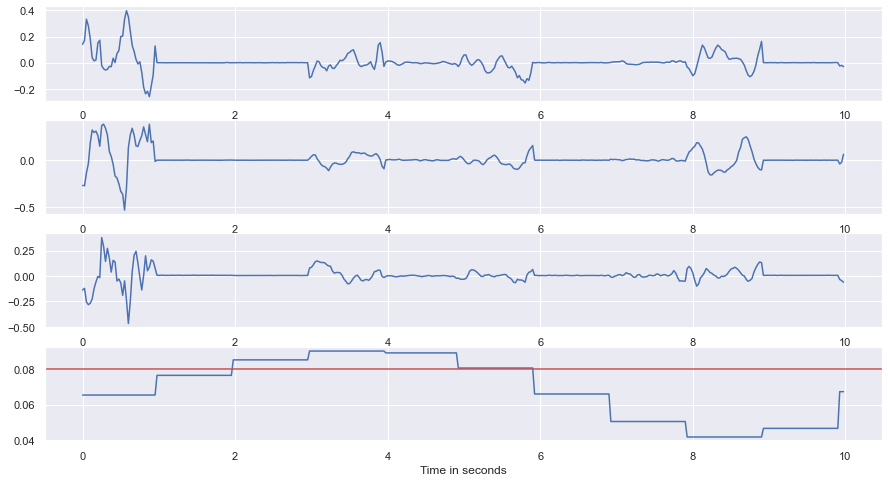

In [15]:
sampling_freq = 40
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Time in seconds")
time = np.arange(zoomed['x'].size)/sampling_freq
ax[0].plot(time,"x",data=zoomed)
ax[1].plot(time,"y",data=zoomed)
ax[2].plot(time,"z",data=zoomed)
ax[3].plot(time,'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

### Spliting Training & Test according to participants

In [13]:
participants = list(pids)
print(participants)

['BK7610', 'BU4707', 'CC6740', 'DC6359', 'DK3500', 'HV0618', 'JB3156', 'JR8022', 'MC7070', 'MJ8002', 'PC6771', 'SA0297', 'SF3079']


In [14]:
random.seed(100)
def Diff(li1, li2):
  return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [15]:
p_tr_index = random.sample(range(0, 13), 9)  # 70%13 = 9.1~9
p_te_index = Diff(list(range(0, 13)),p_tr_index)  #30%13 = 3.9~4

In [16]:
p_te_index

[8, 1, 10, 9]

In [17]:
p_tr_index

[2, 7, 11, 12, 6, 5, 3, 4, 0]

In [18]:
assert len(p_tr_index) + len(p_te_index) == 13

In [19]:
p_te=[]
p_tr = []
for index in p_tr_index:
    p_tr.append(participants[index])
for index in p_te_index:
    p_te.append(participants[index])

In [20]:
p_tr

['CC6740',
 'JR8022',
 'SA0297',
 'SF3079',
 'JB3156',
 'HV0618',
 'DC6359',
 'DK3500',
 'BK7610']

In [21]:
p_te

['MC7070', 'BU4707', 'PC6771', 'MJ8002']

In [22]:
df_train = pd.DataFrame()
for pid in p_tr:
    tmp = large_df[large_df["pid"]==pid]
    df_train = df_train.append(tmp)

In [23]:
df_train

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493741188,0.041870,1493741188015,CC6740,-4.696118,-16.039703,6.315768,0
1,1493741188,0.041870,1493741188039,CC6740,-8.342324,-6.281204,-9.354126,0
2,1493741188,0.041870,1493741188065,CC6740,-6.992756,-1.318486,-8.665682,0
3,1493741188,0.041870,1493741188089,CC6740,-6.556036,1.632029,-3.295139,0
4,1493741188,0.041870,1493741188217,CC6740,-7.352158,2.141843,2.943863,0
...,...,...,...,...,...,...,...,...
669,1493767186,0.148265,1493767186893,BK7610,-0.007300,0.022000,-0.016600,1
670,1493767186,0.148265,1493767186919,BK7610,-0.019100,0.007100,-0.028900,1
671,1493767186,0.148265,1493767186943,BK7610,-0.009000,-0.006900,-0.018800,1
672,1493767186,0.148265,1493767186969,BK7610,0.004800,-0.006400,-0.016400,1


In [24]:
df_test = pd.DataFrame()
for pid in p_te:
    tmp = large_df[large_df["pid"]==pid]
    df_test = df_test.append(tmp)

In [25]:
df_test

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493746471,0.091933,1493746471011,MC7070,0.0013,-0.0008,0.0075,1
1,1493746471,0.091933,1493746471037,MC7070,-0.0007,0.0014,0.0069,1
2,1493746471,0.091933,1493746471061,MC7070,-0.0007,0.0002,0.0070,1
3,1493746471,0.091933,1493746471087,MC7070,0.0005,-0.0007,0.0074,1
4,1493746471,0.091933,1493746471111,MC7070,-0.0021,-0.0002,0.0072,1
...,...,...,...,...,...,...,...,...
315,1493783820,0.040976,1493783820887,MJ8002,0.0015,-0.0029,-0.0056,0
316,1493783820,0.040976,1493783820912,MJ8002,0.0023,-0.0010,-0.0050,0
317,1493783820,0.040976,1493783820937,MJ8002,0.0017,0.0001,-0.0048,0
318,1493783820,0.040976,1493783820961,MJ8002,0.0016,-0.0020,-0.0039,0


# Window size = 5 seconds 
5 seconds = 40*5 samples = 200 samples
<br>
step_size = 25 (Since the data is taken at 25 miliseconds)

In [26]:
x_list = []
y_list = []
z_list = []
train_labels = []
window_size = 200
step_size = 5

for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x'].values[i: i + 200]
    ys = df_train['y'].values[i: i + 200]
    zs = df_train['z'].values[i: i + 200]
    label = (df_train['label'][i: i + 200]).max()
    #print(label)

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [27]:
len(train_labels)

888

In [28]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

In [29]:
# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/200)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/200)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/200))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/200)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/200)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/200))

In [30]:
X_train

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness,z_skewness,x_kurtosis,y_kurtosis,z_kurtosis,x_energy,y_energy,z_energy,avg_result_accl,sma
0,-0.064953,0.090450,0.133395,2.312713,1.579487,1.425638,0.798886,0.569938,0.528983,-11.090120,...,-5.978239,-2.777119,22.812354,56.055238,20.049086,5.352863,2.502961,2.050238,1.242245,1.884047
1,0.072615,0.178151,0.216236,2.069259,0.983566,0.956509,0.647930,0.477616,0.434708,-11.090120,...,-1.721038,-1.914675,33.694475,19.817062,17.250263,4.287106,0.999141,0.961667,1.006397,1.509352
2,0.016355,0.142934,0.267611,1.201090,0.824471,0.761276,0.448601,0.415186,0.425525,-9.735878,...,-2.656904,0.774111,24.392764,20.581380,6.447224,1.442884,0.700182,0.651156,0.815173,1.232808
3,0.069500,0.081248,0.312087,0.976311,1.199820,0.710089,0.413918,0.454130,0.435608,-3.844740,...,-6.545455,1.753319,9.733220,64.668463,5.099015,0.958014,1.446170,0.601625,0.819366,1.232189
4,0.074047,0.073427,0.317342,0.976624,1.201722,0.709935,0.418033,0.459370,0.437772,-3.844740,...,-6.496379,1.732822,9.726851,64.072351,5.054437,0.959276,1.449528,0.604713,0.829876,1.249147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,-0.014124,-0.001657,0.008292,0.116987,0.095321,0.096842,0.066150,0.052831,0.051631,-0.748000,...,-0.400626,-1.101338,10.021900,6.437670,9.565213,0.013885,0.009089,0.009447,0.113891,0.169161
884,-0.008185,0.001781,0.006564,0.109818,0.092827,0.093069,0.058514,0.050397,0.048463,-0.748000,...,-0.417122,-1.371089,13.250746,7.210470,11.019427,0.012127,0.008620,0.008705,0.106428,0.157854
885,-0.009496,0.003408,0.003999,0.107041,0.090719,0.090399,0.055969,0.048268,0.045959,-0.748000,...,-0.411771,-1.530881,14.688606,8.033157,12.320141,0.011548,0.008242,0.008188,0.101148,0.149952
886,-0.002986,0.005642,0.000856,0.098358,0.087785,0.087143,0.048548,0.045954,0.043635,-0.748000,...,-0.391378,-1.763604,20.985584,9.265043,14.105740,0.009683,0.007738,0.007595,0.093179,0.137584


In [31]:
len(x_list)

888

# Fourier Transform

C:\Users\shubh\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


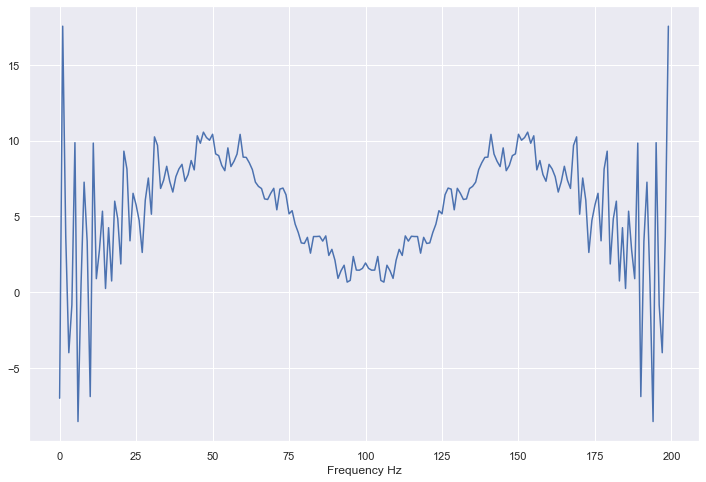

In [32]:
pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.xlabel("Frequency Hz")
plt.show()

##### the signal is symmetric about the center, so we can take only first half of the wave

C:\Users\shubh\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


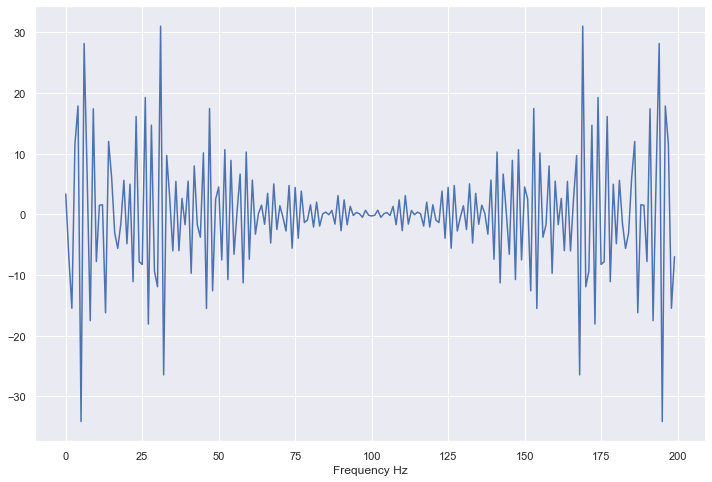

In [33]:
pd.Series(np.fft.fft(pd.Series(x_list)[25])).plot()
plt.xlabel("Frequency Hz")
plt.show()

In [34]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [35]:
X_train

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness_fft,z_skewness_fft,x_kurtosis_fft,y_kurtosis_fft,z_kurtosis_fft,x_energy_fft,y_energy_fft,z_energy_fft,avg_result_accl_fft,sma_fft
0,-0.064953,0.090450,0.133395,2.312713,1.579487,1.425638,0.798886,0.569938,0.528983,-11.090120,...,-0.055095,1.053299,0.226794,-0.908013,-0.112135,2410.296146,1151.182457,503.299151,62.990208,98.503664
1,0.072615,0.178151,0.216236,2.069259,0.983566,0.956509,0.647930,0.477616,0.434708,-11.090120,...,0.440379,0.569058,0.482559,-0.051641,-0.458748,1021.404639,425.116781,429.414721,42.577209,68.872425
2,0.016355,0.142934,0.267611,1.201090,0.824471,0.761276,0.448601,0.415186,0.425525,-9.735878,...,0.465431,0.347440,0.084221,-0.793119,-0.319524,430.145167,315.488206,340.287099,29.407606,48.116429
3,0.069500,0.081248,0.312087,0.976311,1.199820,0.710089,0.413918,0.454130,0.435608,-3.844740,...,0.052301,1.150483,-0.679188,-0.902814,1.073584,379.296292,678.544793,293.012837,34.684007,55.575421
4,0.074047,0.073427,0.317342,0.976624,1.201722,0.709935,0.418033,0.459370,0.437772,-3.844740,...,0.201066,1.183583,-0.704864,-0.845484,1.310939,379.452553,672.285150,292.279394,34.419934,55.270733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,-0.014124,-0.001657,0.008292,0.116987,0.095321,0.096842,0.066150,0.052831,0.051631,-0.748000,...,0.958235,-0.271920,-0.799499,0.344204,-0.612524,7.909092,2.817991,4.386647,3.705384,5.976564
884,-0.008185,0.001781,0.006564,0.109818,0.092827,0.093069,0.058514,0.050397,0.048463,-0.748000,...,0.813498,-0.294441,-0.737421,-0.065045,-0.771747,6.742846,2.612057,4.017975,3.497221,5.644784
885,-0.009496,0.003408,0.003999,0.107041,0.090719,0.090399,0.055969,0.048268,0.045959,-0.748000,...,0.837193,-0.382547,-0.685222,0.256658,-0.440866,6.439533,2.474176,3.847176,3.407368,5.525969
886,-0.002986,0.005642,0.000856,0.098358,0.087785,0.087143,0.048548,0.045954,0.043635,-0.748000,...,0.941188,0.244716,-0.689491,0.688202,0.791117,5.016110,2.382578,3.506927,3.164348,5.152612


# Transform the X_test similarly

In [36]:
x_list = []
y_list = []
z_list = []
test_labels = []
window_size = 200
step_size = 5

for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x'].values[i: i + 200]
    ys = df_test['y'].values[i: i + 200]
    zs = df_test['z'].values[i: i + 200]
    label = (df_test['label'][i: i + 200]).max()

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

In [37]:
len(test_labels)

262

In [38]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

In [39]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/200)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/200)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/200))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/200)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/200)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/200))

In [40]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [41]:
X_test.shape

(262, 94)

In [42]:
X_train.shape

(888, 94)

In [46]:
os.chdir("../")
try:
    os.mkdir("traindata/")
except OSError as error:
    print(error)
print(sorted(os.listdir(root_dir)))
os.chdir(root_dir+"/traindata/")
# print(os.getcwd())
X_train.to_csv("X_train_5sec.csv", index=False)
X_test.to_csv("X_test_5sec.csv", index=False)

# Logistic Model


In [47]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [48]:
len(y_test)

262

In [51]:
pd.DataFrame(y_train).to_csv("y_train_5sec.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test_5sec.csv", index=False)

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)

y_pred = lr.predict(X_train_data_lr)
accuracy = accuracy_score(y_train,y_pred)
print("Accuracy is:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred))

y_pred = lr.predict(X_test_data_lr)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy is:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy is: 0.8907657657657657

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       343
           1       0.90      0.93      0.91       545

    accuracy                           0.89       888
   macro avg       0.89      0.88      0.88       888
weighted avg       0.89      0.89      0.89       888

Accuracy is: 0.6183206106870229

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.59      0.16      0.25       105
           1       0.62      0.92      0.74       157

    accuracy                           0.62       262
   macro avg       0.60      0.54      0.50       262
weighted avg       0.61      0.62      0.55       262



C:\Users\shubh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
X_train

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness_fft,z_skewness_fft,x_kurtosis_fft,y_kurtosis_fft,z_kurtosis_fft,x_energy_fft,y_energy_fft,z_energy_fft,avg_result_accl_fft,sma_fft
0,0.002858,-0.004241,0.001358,0.019215,0.015764,0.022025,0.011005,0.009745,0.015183,-0.0912,...,0.300536,0.259187,-1.146063,-0.248213,-1.091532,0.243707,0.135577,0.341467,0.804457,1.265199
1,0.002883,-0.004416,0.001612,0.019187,0.015537,0.022002,0.010919,0.009547,0.015062,-0.0912,...,0.308514,0.247965,-1.156158,-0.483124,-1.151835,0.243535,0.131012,0.341704,0.799276,1.260457
2,0.002633,-0.004293,0.002007,0.019104,0.015371,0.021908,0.010693,0.009313,0.014851,-0.0912,...,0.412433,0.265169,-1.090658,-0.469397,-1.168940,0.242542,0.132126,0.341808,0.799480,1.266680
3,0.002035,-0.003728,0.002136,0.018587,0.014845,0.021723,0.010173,0.008852,0.014568,-0.0912,...,-0.127698,0.268172,-0.562094,-0.210354,-1.221623,0.229152,0.125804,0.343651,0.787308,1.256478
4,0.001794,-0.003633,0.002268,0.018506,0.014761,0.021626,0.010010,0.008702,0.014303,-0.0912,...,-0.159168,0.226427,-0.520531,-0.431284,-1.211304,0.228062,0.125570,0.343060,0.786956,1.256753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,0.001396,0.023004,0.015380,0.060439,0.087952,0.065721,0.034267,0.058378,0.046697,-0.2881,...,0.239423,0.474255,-0.880052,-0.877027,-0.429560,1.983416,5.203706,2.820657,3.050875,4.799467
612,-0.000062,0.022905,0.014707,0.060200,0.087984,0.066043,0.034244,0.058440,0.047098,-0.2881,...,0.236240,0.486217,-1.328453,-0.886477,-0.079742,1.965909,5.206723,2.852875,3.052438,4.834538
613,-0.003228,0.022071,0.014339,0.063502,0.088263,0.066273,0.037566,0.058924,0.047344,-0.2881,...,0.211023,0.361509,-0.779195,-0.924900,-0.392899,2.226662,5.243964,2.860951,3.118245,4.975668
614,0.001535,0.021053,0.011612,0.070532,0.089060,0.066631,0.040150,0.059718,0.046476,-0.2881,...,0.117244,0.000747,-0.825379,-0.777947,-0.528903,2.708479,5.311458,2.794518,3.182007,5.004021


## SVM MODEL

In [54]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
svc.fit(X_train_data_lr, y_train)

SVC(kernel='linear')

In [55]:
y_pred_svm_train = svc.predict(X_train_data_lr)
y_pred_svm_test = svc.predict(X_test_data_lr)

In [56]:
print("Accuracy is:", accuracy_score(y_train, y_pred_svm_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_svm_train))

Accuracy is: 0.9099099099099099

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       343
           1       0.91      0.95      0.93       545

    accuracy                           0.91       888
   macro avg       0.91      0.90      0.90       888
weighted avg       0.91      0.91      0.91       888



In [57]:
print("Accuracy is:", accuracy_score(y_test, y_pred_svm_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svm_test))

Accuracy is: 0.5801526717557252

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.44      0.19      0.27       105
           1       0.61      0.84      0.71       157

    accuracy                           0.58       262
   macro avg       0.53      0.52      0.49       262
weighted avg       0.54      0.58      0.53       262



## Naive Bayes

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
nb = GaussianNB()
param = {'var_smoothing': np.logspace(0,-11,num=100)}
gs_nb = GridSearchCV(estimator=nb, 
                 param_grid=param, 
                # cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')
#gs_nb = nb
gs_nb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.8s finished


GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 7.74263683e-01, 5.99484250e-01, 4.64158883e-01,
       3.59381366e-01, 2.78255940e-01, 2.15443469e-01, 1.66810054e-01,
       1.29154967e-01, 1.00000000e-01, 7.74263683e-02, 5.99484250e-02,
       4.64158883e-02, 3.59381366e-02, 2.78255940e-02, 2.15443469e-02,
       1.66810054e-02, 1.29154967e-02, 1.0000000...
       3.59381366e-09, 2.78255940e-09, 2.15443469e-09, 1.66810054e-09,
       1.29154967e-09, 1.00000000e-09, 7.74263683e-10, 5.99484250e-10,
       4.64158883e-10, 3.59381366e-10, 2.78255940e-10, 2.15443469e-10,
       1.66810054e-10, 1.29154967e-10, 1.00000000e-10, 7.74263683e-11,
       5.99484250e-11, 4.64158883e-11, 3.59381366e-11, 2.78255940e-11,
       2.15443469e-11, 1.66810054e-11, 1.29154967e-11, 1.00000000e-11])},
             scoring='accuracy', verbose=1)

In [59]:
y_pred_nb_train = gs_nb.predict(X_train)
y_pred_nb_test = gs_nb.predict(X_test)

In [60]:
print("Accuracy is:", accuracy_score(y_train, y_pred_nb_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_nb_train,zero_division = 0))

Accuracy is: 0.6137387387387387

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       343
           1       0.61      1.00      0.76       545

    accuracy                           0.61       888
   macro avg       0.31      0.50      0.38       888
weighted avg       0.38      0.61      0.47       888



In [61]:
print("Accuracy is:", accuracy_score(y_test, y_pred_nb_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_nb_test,zero_division = 0))

Accuracy is: 0.5992366412213741

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.60      1.00      0.75       157

    accuracy                           0.60       262
   macro avg       0.30      0.50      0.37       262
weighted avg       0.36      0.60      0.45       262



#modelling only with frequency features# takes too long to run


## Window size = 10 seconds
10 seconds = 40*10 samples = 400 samples
step_size = 25 (Since the data is taken at 25 miliseconds)

In [62]:
x_list = []
y_list = []
z_list = []
train_labels = []
window_size = 400
step_size = 25

for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x'].values[i: i + 400]
    ys = df_train['y'].values[i: i + 400]
    zs = df_train['z'].values[i: i + 400]
    label = (df_train['label'][i: i + 400]).max()

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [63]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

In [64]:
# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/400)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/400)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/400))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/400)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/400)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/400))

C:\Users\shubh\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


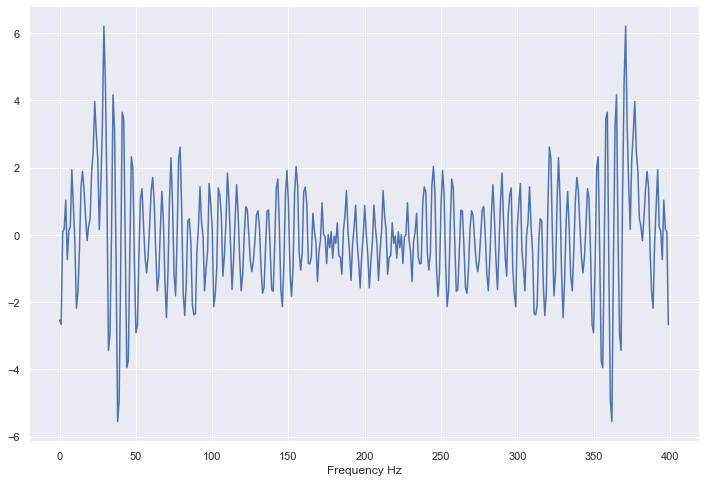

In [65]:
#FOURIER TRANSFORM
pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.xlabel("Frequency Hz")
plt.show()

C:\Users\shubh\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


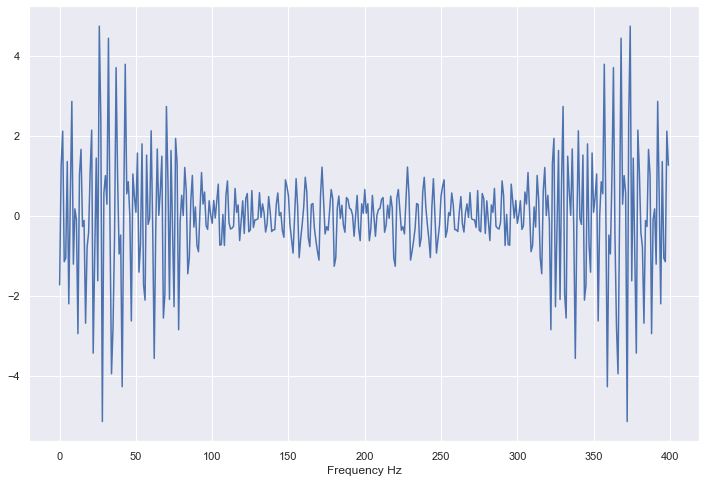

In [66]:
pd.Series(np.fft.fft(pd.Series(x_list)[25])).plot()
plt.xlabel("Frequency Hz")
plt.show()

In [67]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [68]:
x_list = []
y_list = []
z_list = []
test_labels = []
window_size = 400
step_size = 25

for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x'].values[i: i + 400]
    ys = df_test['y'].values[i: i + 400]
    zs = df_test['z'].values[i: i + 400]
    label = (df_test['label'][i: i + 400]).max()

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

In [69]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

In [70]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/400)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/400)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/400))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/400)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/400)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/400))

In [71]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/400)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/400)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/400))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/400)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/400)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/400))

In [72]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [73]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [74]:
X_train.to_csv("X_train_10sec.csv", index=False)
X_test.to_csv("X_test_10sec.csv", index=False)
pd.DataFrame(y_train).to_csv("y_train_10sec.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test_10sec.csv", index=False)


# Logistic Regression

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 42)
lr.fit(X_train_data_lr, y_train)

y_pred = lr.predict(X_train_data_lr)
accuracy = accuracy_score(y_train,y_pred)
print("Accuracy is:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred))

y_pred = lr.predict(X_test_data_lr)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy is:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy is: 0.9294117647058824

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        30
           1       0.94      0.98      0.96       140

    accuracy                           0.93       170
   macro avg       0.91      0.84      0.87       170
weighted avg       0.93      0.93      0.93       170

Accuracy is: 0.8444444444444444

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.94      0.86      0.90        35

    accuracy                           0.84        45
   macro avg       0.78      0.83      0.80        45
weighted avg       0.87      0.84      0.85        45



## SVM

In [76]:
#svm
#alternate
from sklearn.svm import SVC
svc = SVC(kernel='sigmoid')
svc.fit(X_train, y_train)
y_pred_svm_train = svc.predict(X_train)
y_pred_svm_test = svc.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_svm_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_svm_train))

print("Accuracy is:", accuracy_score(y_test, y_pred_svm_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svm_test))

Accuracy is: 0.8235294117647058

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.82      1.00      0.90       140

    accuracy                           0.82       170
   macro avg       0.41      0.50      0.45       170
weighted avg       0.68      0.82      0.74       170

Accuracy is: 0.7777777777777778

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.78      1.00      0.88        35

    accuracy                           0.78        45
   macro avg       0.39      0.50      0.44        45
weighted avg       0.60      0.78      0.68        45



C:\Users\shubh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Naive Bayes

In [77]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb_train = nb.predict(X_train)
y_pred_nb_test = nb.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_nb_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_nb_train))
print("Accuracy is:", accuracy_score(y_test, y_pred_nb_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_nb_test))

Accuracy is: 0.4

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.23      1.00      0.37        30
           1       1.00      0.27      0.43       140

    accuracy                           0.40       170
   macro avg       0.61      0.64      0.40       170
weighted avg       0.86      0.40      0.42       170

Accuracy is: 0.2222222222222222

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.22      1.00      0.36        10
           1       0.00      0.00      0.00        35

    accuracy                           0.22        45
   macro avg       0.11      0.50      0.18        45
weighted avg       0.05      0.22      0.08        45



C:\Users\shubh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
#modified naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
nb = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9,num=100)}
gs_nb = GridSearchCV(estimator=nb, 
                 param_grid=param, 
             #    cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')
gs_nb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.6s finished


GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3101297...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [79]:
y_pred_nb_train = gs_nb.predict(X_train)
y_pred_nb_test = gs_nb.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_nb_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_nb_train,zero_division=1))
print("Accuracy is:", accuracy_score(y_test, y_pred_nb_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_nb_test,zero_division=1))

Accuracy is: 0.8235294117647058

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        30
           1       0.82      1.00      0.90       140

    accuracy                           0.82       170
   macro avg       0.91      0.50      0.45       170
weighted avg       0.85      0.82      0.74       170

Accuracy is: 0.7777777777777778

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        10
           1       0.78      1.00      0.88        35

    accuracy                           0.78        45
   macro avg       0.89      0.50      0.44        45
weighted avg       0.83      0.78      0.68        45



## window size = 2 sec
Window size = 2 seconds 2 seconds = 40*2 samples = 80 samples step_size = 25 (Since the data is taken at 25 miliseconds)

In [80]:
x_list = []
y_list = []
z_list = []
train_labels = []
window_size = 80
step_size = 25

for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x'].values[i: i + 80]
    ys = df_train['y'].values[i: i + 80]
    zs = df_train['z'].values[i: i + 80]
    label = (df_train['label'][i: i + 80]).max()

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [81]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

In [82]:
# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/80)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/80)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/80))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/80)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/80)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/80))


In [83]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [84]:
x_list = []
y_list = []
z_list = []
test_labels = []
window_size = 80
step_size = 25

for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x'].values[i: i +80]
    ys = df_test['y'].values[i: i + 80]
    zs = df_test['z'].values[i: i + 80]
    label = (df_test['label'][i: i + 80]).max()

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

In [85]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

In [86]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/80)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/80)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/80))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/80)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/80)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/80))


In [87]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/80)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/80)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/80))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/80)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/80)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/80))

In [88]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [89]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [90]:
X_train.to_csv("X_train_2sec.csv", index=False)
X_test.to_csv("X_test_2sec.csv", index=False)
pd.DataFrame(y_train).to_csv("y_train_2sec.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test_2sec.csv", index=False)

In [91]:
#logistic regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 42)
lr.fit(X_train_data_lr, y_train)

y_pred = lr.predict(X_train_data_lr)
accuracy = accuracy_score(y_train,y_pred)
print("Accuracy is:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred))

y_pred = lr.predict(X_test_data_lr)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy is:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy is: 0.8688524590163934

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       104
           1       0.87      0.82      0.84        79

    accuracy                           0.87       183
   macro avg       0.87      0.86      0.87       183
weighted avg       0.87      0.87      0.87       183

Accuracy is: 0.7413793103448276

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        31
           1       0.73      0.70      0.72        27

    accuracy                           0.74        58
   macro avg       0.74      0.74      0.74        58
weighted avg       0.74      0.74      0.74        58



In [92]:
#svm

#svm
#alternate
from sklearn.svm import SVC
svc = SVC(kernel='sigmoid')
svc.fit(X_train, y_train)
y_pred_svm_train = svc.predict(X_train)
y_pred_svm_test = svc.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_svm_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_svm_train))

print("Accuracy is:", accuracy_score(y_test, y_pred_svm_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svm_test))

Accuracy is: 0.5683060109289617

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.57      1.00      0.72       104
           1       0.00      0.00      0.00        79

    accuracy                           0.57       183
   macro avg       0.28      0.50      0.36       183
weighted avg       0.32      0.57      0.41       183

Accuracy is: 0.5344827586206896

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.53      1.00      0.70        31
           1       0.00      0.00      0.00        27

    accuracy                           0.53        58
   macro avg       0.27      0.50      0.35        58
weighted avg       0.29      0.53      0.37        58



C:\Users\shubh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb_train = nb.predict(X_train)
y_pred_nb_test = nb.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_nb_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_nb_train))
print("Accuracy is:", accuracy_score(y_test, y_pred_nb_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_nb_test))

Accuracy is: 0.48633879781420764

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.73      0.15      0.25       104
           1       0.45      0.92      0.61        79

    accuracy                           0.49       183
   macro avg       0.59      0.54      0.43       183
weighted avg       0.61      0.49      0.41       183

Accuracy is: 0.46551724137931033

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.47      1.00      0.64        27

    accuracy                           0.47        58
   macro avg       0.23      0.50      0.32        58
weighted avg       0.22      0.47      0.30        58



C:\Users\shubh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
#modified naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
nb = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9,num=100)}
gs_nb = GridSearchCV(estimator=nb, 
                 param_grid=param, 
             #    cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')
gs_nb.fit(X_train, y_train)
y_pred_nb_train = gs_nb.predict(X_train)
y_pred_nb_test = gs_nb.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_nb_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_nb_train,zero_division=1))
print("Accuracy is:", accuracy_score(y_test, y_pred_nb_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_nb_test,zero_division=1))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy is: 0.5683060109289617

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.57      1.00      0.72       104
           1       1.00      0.00      0.00        79

    accuracy                           0.57       183
   macro avg       0.78      0.50      0.36       183
weighted avg       0.75      0.57      0.41       183

Accuracy is: 0.5344827586206896

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.53      1.00      0.70        31
           1       1.00      0.00      0.00        27

    accuracy                           0.53        58
   macro avg       0.77      0.50      0.35        58
weighted avg       0.75      0.53      0.37        58



[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.4s finished


## modellig with window size = 3
Window size = 3 seconds 3 seconds = 40*13 samples = 120 samples step_size = 25 (Since the data is taken at 25 miliseconds)

In [95]:
x_list = []
y_list = []
z_list = []
train_labels = []
window_size = 120
step_size = 25

for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x'].values[i: i + 120]
    ys = df_train['y'].values[i: i + 120]
    zs = df_train['z'].values[i: i + 120]
    label = (df_train['label'][i: i + 120]).max()

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [96]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

In [98]:
# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/120)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/120)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/120))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/120)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/120)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/120))

In [99]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [100]:
x_list = []
y_list = []
z_list = []
test_labels = []
window_size = 120
step_size = 25

for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x'].values[i: i + 120]
    ys = df_test['y'].values[i: i + 120]
    zs = df_test['z'].values[i: i + 120]
    label = (df_test['label'][i: i + 120]).max()

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

In [90]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

In [91]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/120)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/120)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/120))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/120)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/120)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/120))

In [92]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/120)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/120)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/120))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/120)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/120)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/120))

In [93]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [94]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 42)
lr.fit(X_train_data_lr, y_train)

y_pred = lr.predict(X_train_data_lr)
accuracy = accuracy_score(y_train,y_pred)
print("Accuracy is:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred))

y_pred = lr.predict(X_test_data_lr)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy is:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy is: 0.8740157480314961

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        54
           1       0.88      0.90      0.89        73

    accuracy                           0.87       127
   macro avg       0.87      0.87      0.87       127
weighted avg       0.87      0.87      0.87       127

Accuracy is: 0.8433734939759037

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        57
           1       0.81      0.65      0.72        26

    accuracy                           0.84        83
   macro avg       0.83      0.79      0.81        83
weighted avg       0.84      0.84      0.84        83



In [96]:
#svm
#alternate
from sklearn.svm import SVC
svc = SVC(kernel='sigmoid')
svc.fit(X_train, y_train)
y_pred_svm_train = svc.predict(X_train)
y_pred_svm_test = svc.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_svm_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_svm_train))

print("Accuracy is:", accuracy_score(y_test, y_pred_svm_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svm_test))

Accuracy is: 0.6141732283464567

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.60      0.28      0.38        54
           1       0.62      0.86      0.72        73

    accuracy                           0.61       127
   macro avg       0.61      0.57      0.55       127
weighted avg       0.61      0.61      0.58       127

Accuracy is: 0.3132530120481928

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.31      1.00      0.48        26

    accuracy                           0.31        83
   macro avg       0.16      0.50      0.24        83
weighted avg       0.10      0.31      0.15        83



C:\Users\prara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb_train = nb.predict(X_train)
y_pred_nb_test = nb.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_nb_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_nb_train))
print("Accuracy is:", accuracy_score(y_test, y_pred_nb_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_nb_test))

Accuracy is: 0.6535433070866141

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.71      0.31      0.44        54
           1       0.64      0.90      0.75        73

    accuracy                           0.65       127
   macro avg       0.67      0.61      0.59       127
weighted avg       0.67      0.65      0.62       127

Accuracy is: 0.3132530120481928

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.31      1.00      0.48        26

    accuracy                           0.31        83
   macro avg       0.16      0.50      0.24        83
weighted avg       0.10      0.31      0.15        83



C:\Users\prara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
#modified naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
nb = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9,num=100)}
gs_nb = GridSearchCV(estimator=nb, 
                 param_grid=param, 
             #    cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')
gs_nb.fit(X_train, y_train)
y_pred_nb_train = gs_nb.predict(X_train)
y_pred_nb_test = gs_nb.predict(X_test)
print("Accuracy is:", accuracy_score(y_train, y_pred_nb_train))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_train, y_pred_nb_train,zero_division=1))
print("Accuracy is:", accuracy_score(y_test, y_pred_nb_test))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_nb_test,zero_division=1))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy is: 0.6535433070866141

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.71      0.31      0.44        54
           1       0.64      0.90      0.75        73

    accuracy                           0.65       127
   macro avg       0.67      0.61      0.59       127
weighted avg       0.67      0.65      0.62       127

Accuracy is: 0.3132530120481928

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        57
           1       0.31      1.00      0.48        26

    accuracy                           0.31        83
   macro avg       0.66      0.50      0.24        83
weighted avg       0.78      0.31      0.15        83



[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.0s finished
